In [2]:
%matplotlib inline
import torch
import torchvision
from fastai import *
from fastai.vision import *

In [3]:
path = Path('data')

In [4]:
path.ls()

[PosixPath('data/airplane'),
 PosixPath('data/mnist.pkl.gz'),
 PosixPath('data/train-labels-idx1-ubyte.gz'),
 PosixPath('data/MNIST')]

In [5]:
with gzip.open(path/'mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

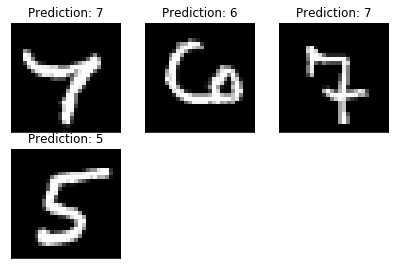

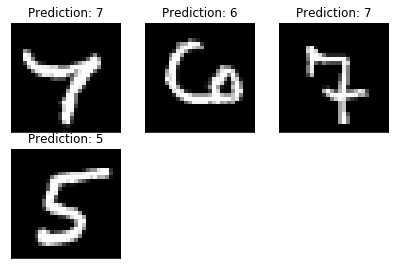

In [37]:
n_epochs = 3
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(4):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [7]:
x_train,y_train,x_valid,y_valid = map(torch.tensor, (x_train,y_train,x_valid,y_valid))
n,c = x_train.shape
x_train.shape, y_train.min(), y_train.max()

(torch.Size([50000, 784]), tensor(0), tensor(9))

In [8]:
bs=64
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
data = DataBunch.create(train_ds, valid_ds, bs=bs)

In [9]:
x,y = next(iter(data.train_dl))
x.shape,y.shape

(torch.Size([64, 784]), torch.Size([64]))

In [10]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10, bias=True)

    def forward(self, xb): return self.lin(xb)

In [11]:
model = Mnist_Logistic().cuda()

In [12]:
model

Mnist_Logistic(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

In [13]:
model.lin

Linear(in_features=784, out_features=10, bias=True)

In [14]:
model(x).shape

torch.Size([64, 10])

In [15]:
lr=2e-2

In [16]:
loss_func = nn.CrossEntropyLoss()

In [17]:
def update(x,y,lr):
    wd = 1e-5
    y_hat = model(x)
    # weight decay
    w2 = 0.
    for p in model.parameters(): w2 += (p**2).sum()
    # add to regular loss
    loss = loss_func(y_hat, y) + w2*wd
    loss.backward()
    with torch.no_grad():
        for p in model.parameters():
            p.sub_(lr * p.grad)
            p.grad.zero_()
    return loss.item()


In [18]:
losses = [update(x,y,lr) for x,y in data.train_dl]

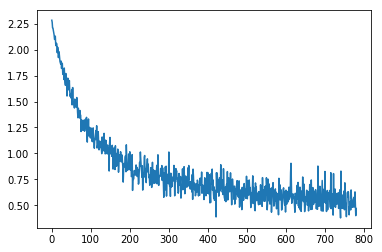

In [19]:
plt.plot(losses);

In [20]:
class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 50, bias=True)
        self.lin2 = nn.Linear(50, 10, bias=True)

    def forward(self, xb):
        x = self.lin1(xb)
        x = F.relu(x)
        return self.lin2(x)

In [21]:
model = Mnist_NN().cuda()

In [22]:
losses = [update(x,y,lr) for x,y in data.train_dl]

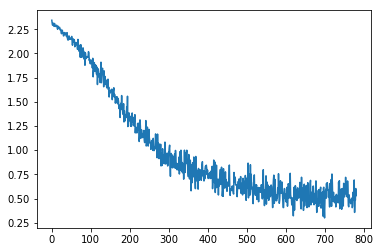

In [23]:
plt.plot(losses);

In [24]:
model = Mnist_NN().cuda()

In [25]:
def update(x,y,lr):
    opt = optim.Adam(model.parameters(), lr)
    y_hat = model(x)
    loss = loss_func(y_hat, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

In [26]:
losses = [update(x,y,1e-3) for x,y in data.train_dl]

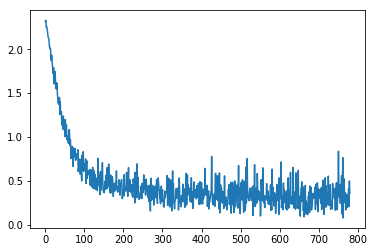

In [27]:
plt.plot(losses);

In [28]:
learn = Learner(data, Mnist_NN(), loss_func=loss_func, metrics=accuracy)

In [29]:
%debug

> <ipython-input-1-c98e9e1493bd>(9)<module>()
      7 
      8 random_seed = 1
----> 9 torch.backends.cudnn.enabled = False
     10 torch.manual_seed(random_seed)
     11 

ipdb> q


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


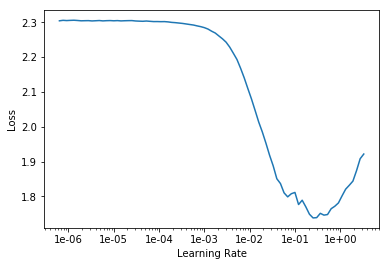

In [30]:
learn.lr_find()
learn.recorder.plot()

In [31]:
learn.fit_one_cycle(3, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.216320,0.219195,0.933800,00:03
1,0.124113,0.105283,0.968100,00:03
2,0.064395,0.089575,0.974300,00:03


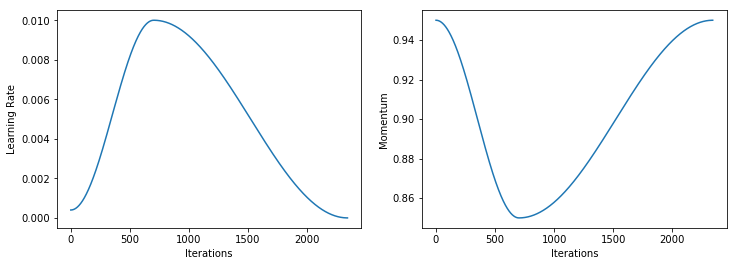

In [32]:
learn.recorder.plot_lr(show_moms=True)

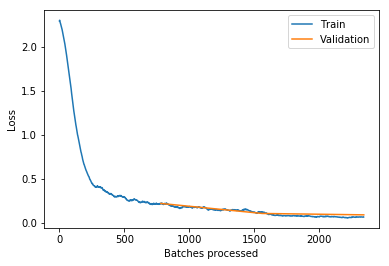

In [33]:
learn.recorder.plot_losses()